In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import itertools
from algorithm import constrained_scipy, generate_Abx, constrained_newton, constrained_steepest_descent
from typing import Callable
import matplotlib.pyplot as plt
from case_studies import *
from dask.distributed import Client

client = Client(threads_per_worker=4, n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50671,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:50692,Total threads: 4
Dashboard: http://127.0.0.1:50693/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:50674,


In [18]:
def evaluate_method(alg: Callable, f: Callable, df: Callable, Hf: Callable,
                    Abx, max_iter: int, epsilon: float, f_name: str,
                    alg_name: str):
    A, b, x0 = Abx
    start_time = time.time()
    xs, grad_norms, _ = alg(f,
                            df,
                            Hf,
                            A,
                            b,
                            x0,
                            tol=epsilon,
                            max_iter=max_iter)
    end_time = time.time()
    cpu_time = end_time - start_time
    try:
        optimal_x, _, _ = constrained_scipy(f, df, Hf, A, b, x0, epsilon,
                                            max_iter)
    except ValueError:
        optimal_x = np.inf
    step = len(grad_norms)
    error = np.linalg.norm(f(xs[-1]) - f(optimal_x))
    distance = np.linalg.norm(xs[-1] - optimal_x)
    distances = [np.linalg.norm(x - optimal_x) for x in xs]
    return step, error, distance, cpu_time, f_name, alg_name, optimal_x, distances, A.shape


def evaluate(params: list,
             Abxs: list,
             max_iter: int = 500,
             epsilon: float = 1.e-10):

    futures = []
    # results = []
    for (f, df, hf), (alg, name) in params:
        for Abx in Abxs:
            # results.append(
            #     evaluate_method(alg, f, df, hf, Abx, max_iter, epsilon,
            #                     f.__name__, name))
            futures.append(
                client.submit(evaluate_method, alg, f, df, hf, Abx, max_iter,
                              epsilon, f.__name__, name))
    results = client.gather(futures)
    steps, errors, distance, cpu_times, obj_funcs, alg_names, optimal_xs, distances, dimensions = zip(
        *results)
    return pd.DataFrame({
        'step': steps,
        'error': errors,
        'distance': distance,
        'cpu_time': cpu_times,
        'obj_func': obj_funcs,
        'alg_name': alg_names,
        'distances': distances,
        'optimal_x': optimal_xs,
        'dimensions': dimensions
    })

In [19]:
dimensions = [(5, 10), (10, 20), (15, 30), (20, 40)]
num_points = 10


def generate_Abxs(dimensions: list, num_points: int):
    Abxs = []
    for dim in dimensions:
        for _ in range(num_points):
            Abxs.append(generate_Abx(dim[0], dim[1]))
    return Abxs


inputs = generate_Abxs(dimensions, num_points)

ALGORITHMS = [constrained_newton, constrained_steepest_descent]
OBJ_FS = [f1, f3, f4, f5]
METHOD_NAMES = ["Newton", 'Steepest Descent']
METRIC_NAMES = ["steps", "error", "distance", "cpu_time"]
DFS = [df1, df3, df4, df5]
HFS = [Hf1, Hf3, Hf4, Hf5]
fs_zip = zip(OBJ_FS, DFS, HFS)
alg_zip = zip(ALGORITHMS, METHOD_NAMES)
params = list(itertools.product(fs_zip, alg_zip))

In [20]:
full_results_df = evaluate(params, inputs, max_iter=1000, epsilon=1.e-7)
full_results_df.to_csv('./maxiter1000_tol1.e-7.csv')

Text(0.5, 1.0, 'steps for different algorithms and objective functions')

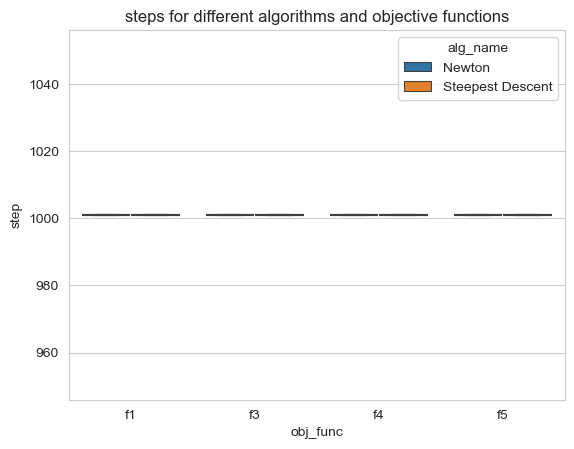

In [21]:
sns.set_style('whitegrid')

sns.boxplot(data=full_results_df,
            x='obj_func',
            y='step',
            hue='alg_name',
            showfliers=False)
plt.title('steps for different algorithms and objective functions')


Text(0.5, 1.0, 'error to the optimal solution for different algorithms and objective functions')

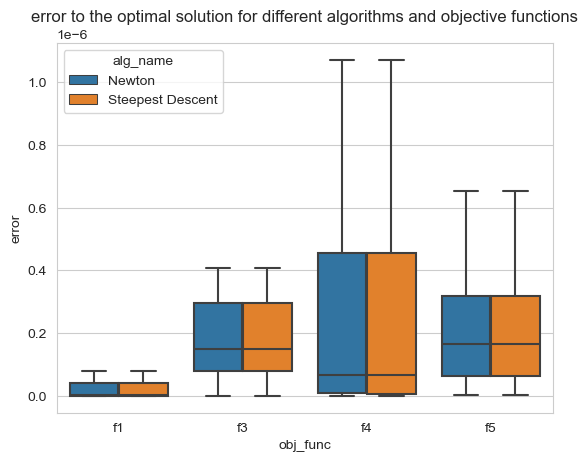

In [22]:
sns.set_style('whitegrid')

sns.boxplot(data=full_results_df,
            x='obj_func',
            y='error',
            hue='alg_name',
            showfliers=False)
plt.title(
    'error to the optimal solution for different algorithms and objective functions'
)


Text(0.5, 1.0, 'distance for different algorithms and objective functions')

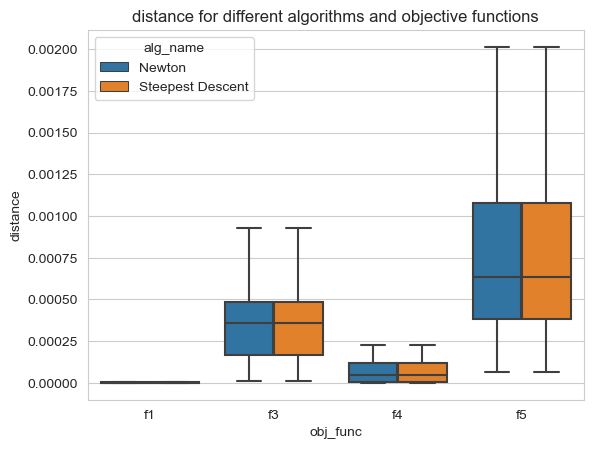

In [23]:
sns.set_style('whitegrid')

sns.boxplot(data=full_results_df,
            x='obj_func',
            y='distance',
            hue='alg_name',
            showfliers=False)
plt.title('distance for different algorithms and objective functions')


Text(0.5, 1.0, 'distance for different algorithms and objective functions')

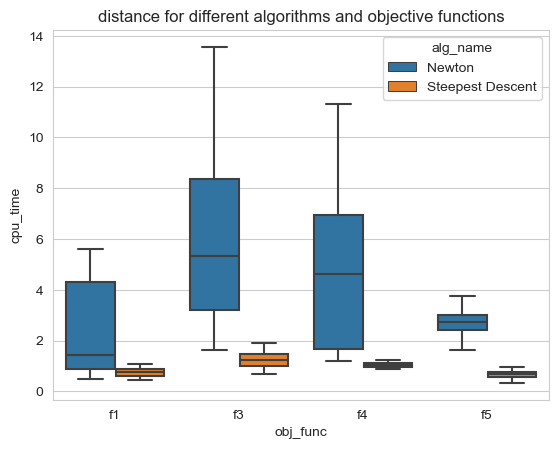

In [24]:
sns.set_style('whitegrid')

sns.boxplot(data=full_results_df,
            x='obj_func',
            y='cpu_time',
            hue='alg_name',
            showfliers=False)
plt.title('distance for different algorithms and objective functions')


In [25]:
full_results_df

,step,error,distance,cpu_time,obj_func,alg_name,distances,optimal_x,dimensions
0,1001,2.959754e-09,3.077366e-07,0.843411,f1,Newton,"[0.2747914800620261, 3.077359699423645e-07, 3....","[-0.181829463752716, 0.044118084041167765, -0....","(5, 10)"
1,1001,1.420405e-07,4.596425e-05,3.003334,f1,Newton,"[0.3465731811311196, 4.596425330694618e-05, 4....","[0.25253696238132595, -0.1640762681715634, 0.0...","(5, 10)"
2,1001,3.030447e-09,1.527727e-08,0.735828,f1,Newton,"[0.6186798103320306, 1.5275510319682662e-08, 1...","[0.14533100762220083, -0.3837882489620633, 0.0...","(5, 10)"
3,1001,1.491232e-07,7.533692e-09,1.073621,f1,Newton,"[0.7098248406653854, 7.538384103641454e-09, 7....","[0.11030285587588734, -0.5411958195751911, 0.1...","(5, 10)"
4,1001,2.930904e-09,1.414233e-07,3.483876,f1,Newton,"[3.2167265861023853, 1.4142333631984802e-07, 1...","[0.739357776924553, -2.080910841645002, 1.4652...","(5, 10)"
...,...,...,...,...,...,...,...,...,...
315,1001,6.537133e-07,2.013119e-03,0.331905,f5,Steepest Descent,"[0.29199642274878335, 0.18572131511663645, 0.1...","[-0.020395151307086072, -0.0846444659175172, 0...","(20, 40)"
316,1001,8.493766e-07,2.002337e-03,0.624786,f5,Steepest Descent,"[0.379223009960721, 0.1798108261196299, 0.1312...","[-0.14948799002711607, -0.13183354309576872, 0...","(20, 40)"
317,1001,1.692232e-07,8.091570e-04,0.386224,f5,Steepest Descent,"[0.4053480298294515, 0.19857325479229782, 0.10...","[-0.14826623027922203, -0.021536382449170027, ...","(20, 40)"
318,1001,7.532833e-08,4.703029e-04,0.454722,f5,Steepest Descent,"[0.3129270321622071, 0.13704076716482247, 0.07...","[0.022274451475558333, -0.08009306455941201, -...","(20, 40)"


In [27]:
points = []
steps = []
distances = []
dimensions = []
obj_funcs = []
algs = []

p_index = 0
for row_dict in full_results_df.to_dict(orient="records"):
    p_indices = [p_index] * len(row_dict['distances'])
    points.extend(p_indices)
    steps += list(range(len(row_dict['distances'])))
    distances.extend(row_dict['distances'])
    dimensions.extend([row_dict['dimensions']] * len(row_dict['distances']))
    obj_funcs.extend([row_dict['obj_func']] * len(row_dict['distances']))
    algs.extend([row_dict['alg_name']] * len(row_dict['distances']))
    p_index += 1

flatten_results = pd.DataFrame({
    'points': points,
    'distances': distances,
    'dimensions': dimensions,
    'obj_func': obj_funcs,
    'alg_name': algs,
    'steps': steps
})

flatten_results

,points,distances,dimensions,obj_func,alg_name,steps
0,0,2.747915e-01,"(5, 10)",f1,Newton,0
1,0,3.077360e-07,"(5, 10)",f1,Newton,1
2,0,3.077360e-07,"(5, 10)",f1,Newton,2
3,0,3.077360e-07,"(5, 10)",f1,Newton,3
4,0,3.077360e-07,"(5, 10)",f1,Newton,4
...,...,...,...,...,...,...
320315,319,1.308013e-03,"(20, 40)",f5,Steepest Descent,996
320316,319,1.308013e-03,"(20, 40)",f5,Steepest Descent,997
320317,319,1.308013e-03,"(20, 40)",f5,Steepest Descent,998
320318,319,1.308013e-03,"(20, 40)",f5,Steepest Descent,999


/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


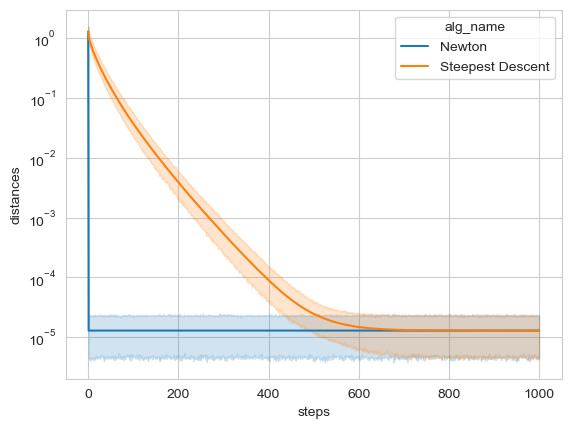

In [32]:
sns.lineplot(data=flatten_results.query('obj_func=="f1"'),
             x='steps',
             y='distances',
             hue='alg_name')
plt.yscale('log')

/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


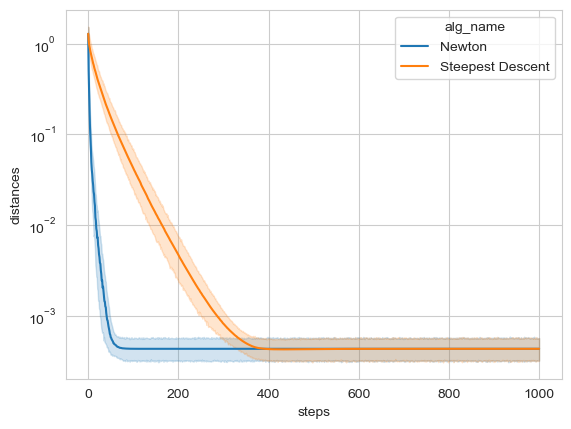

In [33]:
sns.lineplot(data=flatten_results.query('obj_func=="f3"'),
             x='steps',
             y='distances',
             hue='alg_name')
plt.yscale('log')

/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


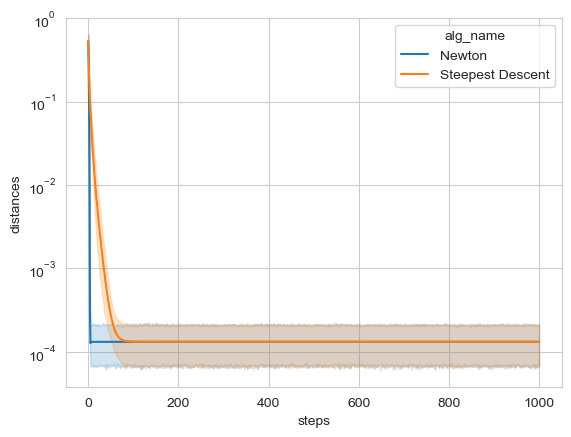

In [34]:
sns.lineplot(data=flatten_results.query('obj_func=="f4"'),
             x='steps',
             y='distances',
             hue='alg_name')
plt.yscale('log')

/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/qzhng/anaconda3/envs/NO/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


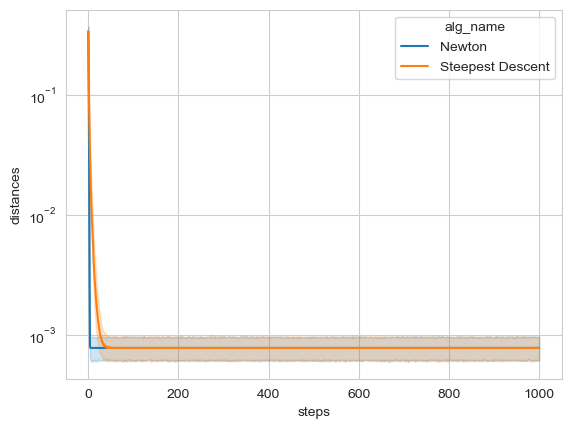

In [35]:
sns.lineplot(data=flatten_results.query('obj_func=="f5"'),
             x='steps',
             y='distances',
             hue='alg_name')
plt.yscale('log')